In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random
import seaborn as sns
sns.set()

random.seed(42)

class memory_cell():
    """
    Memory cell to store the impression of another agent is simply its defection rate
    
    Attributes
    ------------
    defect_number_ : Number of defection
    play_number_   : Number of Plays
    
    """
    def __init__(self, act = 'C'):
        self.defect_number_ = 0.0
        self.play_number_ = 1.0
        
        if act == 'D' : self.defect_number_ += 1.0
    
    def update(self, act):
        if act == 'D' : self.defect_number_ += 1.0
        self.play_number_ += 1.0
    
    def impression(self):
        return self.defect_number_/max(1.0, self.play_number_)
    
class agent():
    """
    Player of a Prisoners Dilemma Game. 
    
    Parameters
    ------------
    ID            : Unique identifier for the agent
    pD            : Probability of defection
    capacity      : Memory Size/Capacity 
    
        
    Attributes
    ------------
    score_                  : Accumulates payoffs (define success/fitness)
    memory_for_defectors_   : 
    memory_for_cooperators_ :
                 Store information about a limited number (M) of opponent players.
                 Dictionary (key, value) = (other_agent, memory_cell)
    
    """
    def __init__(self, ID, pD = 1, M = 1):
        self.ID = ID
        self.pD = pD
        self.capacity = M
        self.score_ = 0
        
        self.memory_for_defectors_ = dict()
        self.memory_for_cooperators_ = dict()
        
    def act(self):
        """
        Two possible actions
            - defect with probability pD
            - cooperate with probability 1 - pD
        """
        if np.random.rand() < self.pD:
            return 'D'
        return 'C'
    
    def know(self, other):
        return (other in self.memory_for_defectors_) or (other in self.memory_for_cooperators_)
    
    def is_memory_full(self):
        c,d = len(self.memory_for_cooperators_), len(self.memory_for_defectors_)
        return  c + d >= self.capacity
    
    def perceive_as_defector(self, other):
        return other in self.memory_for_defectors_
    
    def take_payoff(self, payoff):
        self.score_ += payoff
    
    def learn(self, other, act):  
        if other in self.memory_for_defectors_:
            print("-- Bug -- Dont play with a defector!! -- ")
        elif other in self.memory_for_cooperators_:
            self.memory_for_cooperators_[other].update(act)
            
            # a cooperator became a defector!
            if self.memory_for_cooperators_[other].impression() > 0.5:
                self.memory_for_defectors_[other] = self.memory_for_cooperators_[other]
                del self.memory_for_cooperators_[other]
        else: # first play with an unknown player
            if self.is_memory_full(): 
                self.forget()
            if act == 'C':
                self.memory_for_cooperators_[other] = memory_cell(act)
            else:
                self.memory_for_defectors_[other] = memory_cell(act)
        
    def forget(self):   
        if len(self.memory_for_cooperators_) > 0:
            f = random.choice(list(self.memory_for_cooperators_.keys()))
            del self.memory_for_cooperators_[f]
        else:
            f = random.choice(list(self.memory_for_defectors_.keys()))
            del self.memory_for_defectors_[f]

    def display(self):
        return [(k.ID, v.impression()) for (k,v) in self.memory_for_cooperators_.items()] + [(k.ID, v.impression()) for (k,v) in self.memory_for_defectors_.items()]
    
    

In [2]:
class EAgent(agent):
    def __init__(self, ID, pD = 1.0, MRatio = 1.0 , N =100):
        self.N = N
        self.genome = np.array([pD, MRatio])
        super().__init__(ID, pD = self.genome[0], M = int(N * self.genome[1]))
        
    def set_gene(self, new_gene):
        self.genome = new_gene
        self.reset()
        
    def reset(self):
        self.pD = self.genome[0]
        self.capacity = self.N * self.genome[1]
        self.score_ = 0
        
        self.memory_for_defectors_.clear()
        self.memory_for_cooperators_.clear()
        
    def fitness(self):
        return self.score_

In [3]:
class abm():
    def __init__(self, N = 50, tau = 20, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N = N
        self.time = self.N * self.N * tau
        self.population = [EAgent(i, pD = np.random.rand(), MRatio = np.random.rand(), N = self.N) for i in range(self.N)]
        self.payoff = payoff
        
    def renaissance(self, new_population):
        self.population = new_population
        for player in self.population:
            player.reset()
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.take_payoff(self.payoff[A_action+B_action])
            B.take_payoff(self.payoff[B_action+A_action])
            
    def display(self):
        self.df = pd.DataFrame(columns=['ID','pD', 'mRatio', 'score'])
        for A in self.population:
            self.df.loc[A.ID] = pd.Series({'ID':A.ID, 'pD':A.genome[0], 'mRatio':A.genome[1], 'score':A.score_})
        return self.df

# Evolution

In [4]:
class evolution():
    def __init__(self, N = 50, tau = 30, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}): 
        self.sim = abm(N = N, tau = tau, payoff = payoff)
        self.sim.world()
        
        self.N = N
        self.population = self.sim.population
        self.update_probabilities()
        self.df_evolution = [self.sim.display()]

    def update_probabilities(self):
        self.success = {i: self.population[i].fitness() for i in range(self.N)} 
        # to convert negative payoffs into probabilities, we substract min
        min_success = min(self.success.values()) 
        for i in range(self.N):
            self.success[i] = self.success[i] - min_success
        
        total_success = sum(self.success.values())
        self.reproduction_probability = {i: self.success[i]/total_success for i in range(self.N)}

    def selection(self):
        pr = [self.reproduction_probability[i] for i in range(self.N)]
        select = np.random.choice(self.N, 2, replace= False, p=pr)
        return select
    
    def crossover(self, selectedParents):
        parent0 = self.population[selectedParents[0]].genome
        parent1 = self.population[selectedParents[1]].genome

        cut = np.random.randint(len(parent0)-1) + 1 # to avoid cut = 0 (exact copy of parent1)
        child_gene = np.hstack((parent0[:cut],parent1[cut:]))
        return child_gene
    
    def mutation(self, child_gene, p = 1):
        mutation_point = np.random.randint(len(child_gene))
        if np.random.rand() < p:
            child_gene[mutation_point] = np.random.rand()
        return child_gene
    
    def create_offspring(self):
        parents = self.selection()
        child_gene = self.crossover(parents)
        
        child_gene = self.mutation(child_gene)
        return child_gene
    
    def create_new_population(self):
        sorted_by_success = sorted(self.success.items(), key=lambda kv: kv[1])
        self.best_agent = self.population[sorted_by_success[-1][0]]
        
        for i in range(self.N//2):
            child_gene = self.create_offspring()
            agent_id = sorted_by_success[i][0]
            self.population[agent_id].set_gene(child_gene)
        
        self.sim.renaissance(self.population)
        self.sim.world()
        self.df_evolution.append(self.sim.display())
        
        self.update_probabilities()
    
    def evolve(self, G ):
        for i in range(G):
            if i % (G//5) == 0: print(i, len(self.df_evolution))
            self.create_new_population()
        return self.best_agent

In [23]:
world = evolution()
world.evolve(G = 10)

0 1
2 3
4 5
6 7
8 9


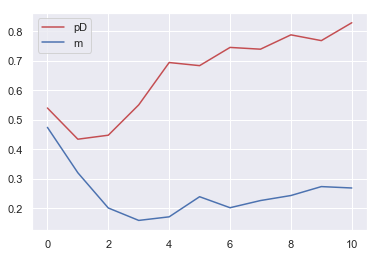

In [25]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()

## beta = 0.1, alpha = 1.5

In [8]:
beta = 0.1
alpha = 1.5
world = evolution(payoff = {'CC':1-beta,'CD':1-alpha-beta,'DC':1,'DD':1-alpha})
world.evolve( G = 50)

0 1
10 11
20 21
30 31
40 41


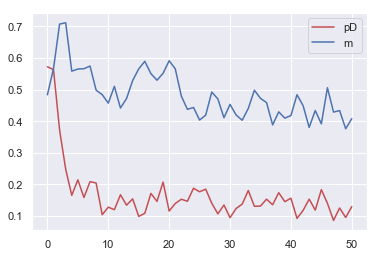

In [9]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()

## beta = 0.2, alpha = 1.5

In [10]:
beta = 0.2
alpha = 1.5
world = evolution(payoff = {'CC':1-beta,'CD':1-alpha-beta,'DC':1,'DD':1-alpha})
world.evolve( G = 50)

0 1
10 11
20 21
30 31
40 41


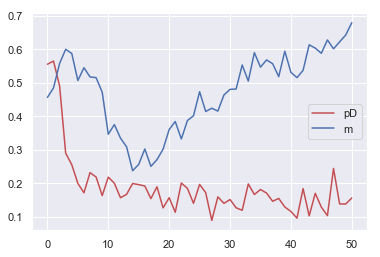

In [11]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()

## beta = 0.2, alpha = 1

In [12]:
beta = 0.2
alpha = 1
world = evolution(payoff = {'CC':1-beta,'CD':1-alpha-beta,'DC':1,'DD':1-alpha})
world.evolve( G = 50)

0 1
10 11
20 21
30 31
40 41


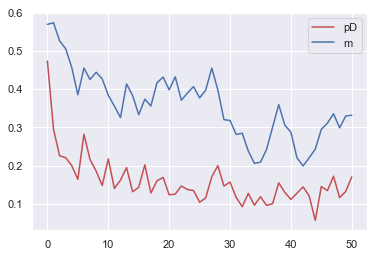

In [13]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()

## beta = 0.25, alpha = 1

In [14]:
beta = 0.25
alpha = 1
world = evolution(payoff = {'CC':1-beta,'CD':1-alpha-beta,'DC':1,'DD':1-alpha})
world.evolve( G = 50)

0 1
10 11
20 21
30 31
40 41


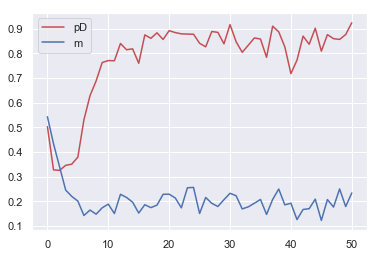

In [15]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()

## beta = 0.22, alpha = 1

In [16]:
beta = 0.22
alpha = 1
world = evolution(payoff = {'CC':1-beta,'CD':1-alpha-beta,'DC':1,'DD':1-alpha})
world.evolve( G = 50)

0 1
10 11
20 21
30 31
40 41


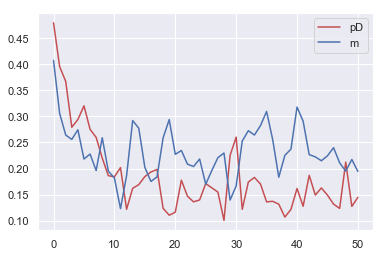

In [17]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()

## beta = 0.22, alpha = 1.2

In [28]:
beta = 0.22
alpha = 1.2
world = evolution(payoff = {'CC':1-beta,'CD':1-alpha-beta,'DC':1,'DD':1-alpha})
world.evolve( G = 50)

0 1
10 11
20 21
30 31
40 41


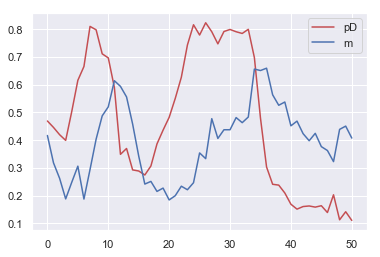

In [29]:
pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "pD", color = 'r')
plt.plot(m, label = "m")
plt.legend()